In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score, make_scorer
%matplotlib inline 
import sys
sys.path.append("../Src")

# 1. Using the Modeller class

Loading features and instantiating the Modeller class

In [71]:
features = pd.read_csv("../Data/Features/features_all_id_6000_evaluation.csv")

In [73]:
features_list = ['0_Google', '1_Google',
       '2_Google', '3_Google', '4_Google', '5_Google', '6_Google', '7_Google',
       '8_Google', '9_Google', '0_Sentinel', '1_Sentinel', '2_Sentinel',
       '3_Sentinel', '4_Sentinel', '5_Sentinel', '6_Sentinel', '7_Sentinel',
       '8_Sentinel', '9_Sentinel', 'nightlights', 'distance_school',
       'distance_hospital', 'distance_tree', 'max_NDVI', 'max_NDBI',
       'max_NDWI', 'fatalities_10000', 'fatalities_100000', 'n_events_10000',
       'n_events_100000', 'violence_civ_10000', 'violence_civ_100000',
       'weighted_sum_fatalities_by_dist', 'distance_to_acled_event']
from modeller import Modeller
X, y = features.reset_index(), features['FCS_mean']
modeller = Modeller(X, rs_features=features_list, spatial_features=["gpsLatitude", "gpsLongitude"], scoring='r2', cv_loops=20)

In [74]:
kNN_pipeline = modeller.make_model_pipeline('kNN')
kNN_scores = modeller.compute_scores(kNN_pipeline, y)
kNN_R2_mean = kNN_scores.mean()
kNN_R2_std = kNN_scores.std()
print("kNN_R2_mean: ", kNN_R2_mean, "kNN_R2_std: ", kNN_R2_std)

kNN_R2_mean:  0.5113735840713777 kNN_R2_std:  0.07245634870925323


In [76]:
from sklearn.model_selection import cross_val_predict
results = pd.DataFrame({
        'yhat': cross_val_predict(kNN_pipeline, X.values, y),
        'y': features['FCS_mean'].values})
import numpy as np
print('MAPE on kNN: ', np.mean(np.abs(results['yhat'] - results['y'])/results['y']))

MAPE on kNN:  0.46403521351835597


In [77]:
Ridge_pipeline = modeller.make_model_pipeline('Ridge')
Ridge_scores = modeller.compute_scores(Ridge_pipeline, y)
Ridge_R2_mean = np.abs(Ridge_scores).mean()
Ridge_R2_std = Ridge_scores.std()
print("Ridge_R2_mean: ", Ridge_R2_mean, "Ridge_R2_std: ", Ridge_R2_std)

Ridge_R2_mean:  0.09034678062371362 Ridge_R2_std:  0.06345442819024727


In [78]:
from sklearn.model_selection import cross_val_predict
results = pd.DataFrame({
        'yhat': cross_val_predict(Ridge_pipeline, X.values, y),
        'y': features['FCS_mean'].values})
import numpy as np
print('MAPE on Ridge: ', np.mean(np.abs(results['yhat'] - results['y'])/results['y']))

MAPE on Ridge:  0.5570895016528906


# 2. Manual

In [80]:
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from sklearn.linear_model import Ridge
import numpy as np
parameters = {"alpha": [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
estimator = Ridge()
data = X[features_list]
data['y'] = y
cv_loops = 10
train_samps = 400
test_samps = 109

results_y = []
results_yhat = []

for i in range(cv_loops):
    print('total samples: ',data.shape[0])
    
    data = data.sample(frac=1).reset_index(drop=True)
    train = data.loc[:train_samps, :]
    test = data.loc[train_samps:, :]

    grid_cv = KFold(4, shuffle=True, random_state=i*333)
    gs = GridSearchCV(estimator=estimator, param_grid=parameters, cv=grid_cv, scoring='neg_mean_absolute_error')

    gs.fit(train[features_list], train['y'])
        
    results_y.extend(test['y'])
    results_yhat.extend(gs.predict(test[features_list]))
    

C:\Users\lorenzo.riches\anaconda\envs\hrm\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


total samples:  509
total samples:  509
total samples:  509
total samples:  509
total samples:  509
total samples:  509
total samples:  509
total samples:  509
total samples:  509
total samples:  509


In [81]:
pd.DataFrame({'y': results_y, 'yhat': results_yhat}).to_clipboard()

# 3. Predictions

In [61]:
yhat_test = np.exp(model.predict(X[200:]))
y_test = np.exp(y[200:])

In [62]:
test_res = pd.DataFrame({'pred': yhat_test, 'true': y_test})

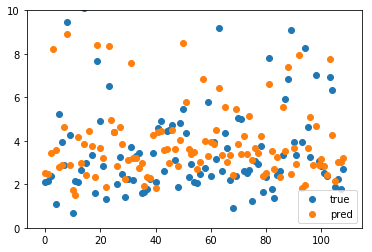

In [64]:
plt.scatter(range(0,109), y_test, label='true')
plt.scatter(range(0,109), yhat_test, label='pred')
plt.ylim((0,10))
plt.legend()
plt.show()

### Mapping Results

In [65]:
results = hh_data[['gpsLatitude', 'gpsLongitude', 'cons']]
results['pred'] = np.exp(model.predict(X))

C:\Users\lorenzo.riches\AppData\Local\Continuum\anaconda3\envs\py35env\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [ ]:
# expanding rows depending on values in cons/pred

In [66]:
plot_df = results.groupby(['gpsLatitude', 'gpsLongitude'], as_index=False).sum()

In [68]:
plot_df = plot_df.loc[plot_df.index.repeat(plot_df['cons'].astype(int))].reset_index(drop=True)

In [76]:
import gmplot
gmap = gmplot.GoogleMapPlotter(1.268255, 32.541539, 8)
gmap.heatmap(plot_df['gpsLatitude'], plot_df['gpsLongitude'], dissipating=True, threshold=1, radius=50, gradient=None, opacity=0.6)
gmap.draw("mymap.html")